# Using MELD to characterize chordin loss-of-function
## Introduction

In this tutorial, we will demonstrate how to use MELD (Manifold Enhancement of Latent Dimensions) to characterize the effect of Cas9-mutagenesis in the zebrafish embryo. We will use a dataset generated by the Klein and Megason labs and published in [Wagner et al. (2018) (doi: 10.1126/science.aar4362)](https://www.ncbi.nlm.nih.gov/pubmed/29700229). Here, zebrafish embryos were injected with Cas9 + gRNAs at the one-cell stage targeting either chordin (*chd*) in the experimental condition or tyrosinase (*tyr*) in the control condition. Embryos were collected in a rough time course from 14-16 hours post fertilization for scRNA-seq and 27,000 cells were recovered.

[Chordin](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CHRD) is a BMP antagonist required for proper specification of dorsally-derived neural tissues([Hammerschmidt et al. (1997)](https://www.ncbi.nlm.nih.gov/pubmed/9007232)). [Tyrosinase](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TYR) is a gene required for melanin production, but does not affect cell type specification at the time points considered in this study.

Here, we will use MELD to quantify the effect of the mutation as was done in the [MELD manuscript](https://doi.org/10.1101/532846) and generate all of the figures described in Sections 2.6 and 2.7.

We will also introduce some basics of preprocessing, visualization and imputation to give an idea of how you might include MELD in a general scRNA-seq analysis workflow.

Here's the order we'll follow:

* [1. Loading the dataset](#1.-Loading-data)  
* [2. Filtering, normalizing, and transforming the data](#2.-Filtering,-normalizing,-and-transforming-the-data)
* [3. Embedding Data Using PHATE](#3.-Embedding-Data-Using-PHATE)
* [4. Using MELD to learn an Enhanced Experimental Signal](#5.-Using-MELD-to-learn-an-Enhanced-Experimental-Signal)
* [5. Isolating the Tailbud - Presomitic Mesoderm cluster](#6.-Isolating-the-Tailbud---Presomitic-Mesoderm-cluster)
* [6. Using the EES to identify gene trends in subtissues of the `tailbud - PSM`](#7.-Using-the-EES-to-identify-gene-trends-in-subtissues-of-the-tailbud---PSM)

## 0. Installing packages

If you haven't installed MELD yet, you can do so from this notebook. We'll also install some other useful packages while we're at it.

In [1]:
!pip install --user meld phate magic-impute cmocean

## 1. Loading data

### 1.1 Downloading and importing data from GEO
We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).

Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

**Standard imports**


In [1]:
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
import cmocean
import sklearn

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# making sure plots & clusters are reproducible
np.random.seed(42)

%load_ext autoreload
%autoreload 2

import scanpy as sc

#### Use `scprep.io.load_csv` to import all three matrices into a DataFrame for each sample (this may take a few minutes)¶

This data is available from [GEO Series GSE112294](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE112294). Note, the entire dataset is roughly 50MB. We will load it directly into this notebook from the web.

Note: By default, `scprep.io.load_csv` loads scRNA-seq data using the Pandas SparseDataFrame [(see Pandas docs)](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_csv`. We are passing a URL as the filename, but you can also use this function to load data already stored on your computer.

Note: There are many helper functions available for loading single cell data in `scprep.io`. Learn more in [the `scprep.io` documentation](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.io).

In [3]:
sample_info = [('GSM3067201', 'chd', 'A'), ('GSM3067202', 'chd', 'B'), ('GSM3067203', 'chd', 'C'),
           ('GSM3067204', 'tyr', 'A'), ('GSM3067205', 'tyr', 'B'), ('GSM3067206', 'tyr', 'C')]
counts_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
             'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}' \
             '.csv.gz'
clusters_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
               'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}_' \
               'clustID.txt.gz'
cluster_names_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE112nnn/GSE112294/' \
                    'suppl/GSE112294_ClusterNames.csv.gz'

In [4]:
sparse = False
counts_matrices = [] 
batch_labels = []
metadata = []
for accession, genotype, replicate in sample_info:
    curr_label = '{}{}'.format(genotype, replicate)
    print('Downloading {accession}.{genotype}.{replicate} ...'.format(accession=accession, genotype=genotype, replicate=replicate))
    
    batch_labels.append(curr_label)
    
    data = scprep.io.load_csv(counts_url.format(accession=accession, genotype=genotype, replicate=replicate),
                              sparse=sparse, cell_axis='column')
    counts_matrices.append(data)
    
    clusters = scprep.io.load_csv(clusters_url.format(accession=accession, genotype=genotype, replicate=replicate),
                       cell_names=data.index, gene_names=['clusterID'], sparse=False)
    metadata.append(clusters)

data, sample_labels = scprep.utils.combine_batches(counts_matrices, batch_labels, append_to_cell_names=True)
metadata, _ = scprep.utils.combine_batches(metadata, batch_labels, append_to_cell_names=True)
data.head()

Row,LOC100000009,LOC100000024,LOC100000058,LOC100000086,LOC100000094,LOC100000098,LOC100000110,LOC100000119,LOC100000140,LOC100000155,...,zte38,zufsp,zw10,zwi,zwilch,zyg11,zymnd12,zyx,zzef1,zzz3
DEW193_TGGGAATT_AGAGACTA_chdA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEW193_TATCTGTC_CTTCGCAC_chdA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DEW193_AGGGTAAA_AAAGCCTA_chdA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
DEW193_CCCGTTCT_GCTTTGGC_chdA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
DEW193_CCAGACAG_TGGGATTC_chdA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Adding the sample labels to the `metadata` DataFrame

We will store all additional information about the cells (e.g. sample labels referring to which batch they were in, cluster IDs, and more) in the `metadata` data frame. This will make it easier to subset the metadata when we filter the counts matrix.

In [5]:
counts_matrices.clear() #to save space
metadata['sample_labels'] = sample_labels
metadata.head()

,clusterID,sample_labels
DEW193_TGGGAATT_AGAGACTA_chdA,72,chdA
DEW193_TATCTGTC_CTTCGCAC_chdA,65,chdA
DEW193_AGGGTAAA_AAAGCCTA_chdA,55,chdA
DEW193_CCCGTTCT_GCTTTGGC_chdA,55,chdA
DEW193_CCAGACAG_TGGGATTC_chdA,55,chdA


In [6]:
metadata['genotype'] = ['chd' if label.startswith('chd') else 'tyr' for label in metadata['sample_labels']]

### Importing published cluster assignments

Now we will load the file that maps clusterIDs (which are `int`s) to cluster names (which are `str`s)

In [7]:
ClusterNamesMaps = scprep.io.load_csv(cluster_names_url, cell_names=False).set_index("ClusterID")
ClusterNamesMaps.head()

,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,04hpf-blastocyst - EVL
1.2,4,04hpf-blastocyst - margin
1.3,4,04hpf-blastocyst - DEL
1.4,4,04hpf-blastocyst - germline
2.0,6,06hpf-non-dorsal margin


We're not interested in having the time points at the start of the cluster name. Fortunately, all of these time points are exactly six characters long, so we can remove them with `pandas` handy string slice method. 

In [8]:
ClusterNamesMaps['ClusterName'] = ClusterNamesMaps['ClusterName'].str.slice(6)
ClusterNamesMaps.head()

,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,blastocyst - EVL
1.2,4,blastocyst - margin
1.3,4,blastocyst - DEL
1.4,4,blastocyst - germline
2.0,6,non-dorsal margin


Now we can select the cluster name corresponding to each cell's cluster ID.

In [9]:
cluster_names = ClusterNamesMaps['ClusterName'].loc[metadata['clusterID']]
cluster_names.index = metadata.index
metadata['cluster'] = cluster_names
metadata.head()

,clusterID,sample_labels,genotype,cluster
DEW193_TGGGAATT_AGAGACTA_chdA,72,chdA,chd,hatching gland
DEW193_TATCTGTC_CTTCGCAC_chdA,65,chdA,chd,differentiating neurons - rohon beard
DEW193_AGGGTAAA_AAAGCCTA_chdA,55,chdA,chd,tailbud - PSM
DEW193_CCCGTTCT_GCTTTGGC_chdA,55,chdA,chd,tailbud - PSM
DEW193_CCAGACAG_TGGGATTC_chdA,55,chdA,chd,tailbud - PSM


## 2. Filtering, normalizing, and transforming the data

### Filtering

We filter the data by:

1. Removing dead cells
2. Filtering by library size
3. Removing genes that are expressed in relatively few cells.

### Filtering cells by library size and filtering genes with low detection

#### Removing lowly detected genes
Here, we'll use `filter_rare_genes` to remove genes detected in fewer than 10 cells. We lack sufficient information about these genes to make inferences about their gene expression.

In [13]:
data = scprep.filter.filter_rare_genes(data)

#### Library size

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the <1% of cells that have very high library sizes.

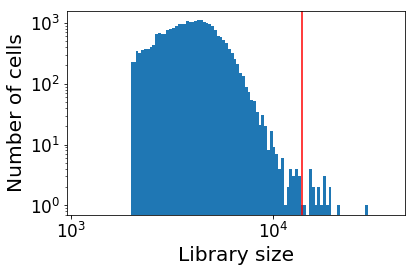

In [14]:
scprep.plot.plot_library_size(data, cutoff=15000);

We can use `scprep.filter` for various filtering tasks. Here, we'll use `filter_library_size` to keep cells below a cutoff of 10,000 UMI/cell.

In [15]:
data, metadata = scprep.filter.filter_library_size(
    data, metadata, cutoff=15000, 
    keep_cells='below')

#### Removing cells with small library size and abnormal expression
During preliminary analysis, a group of 24 cells were identified originating exclusively from the chd embryos. Despite an average library size in the bottom 12% of cells, these cells exhibited 546-fold, 246-fold, and 1210-fold increased expression of Sh3Tc1, LOC101882117, and LOC101885394 respectively. To the best of our knowledge, the function of these genes in development is not described. These cells were excluded from further analysis.

The cell barcodes of these cells are stored in 'excluded_cells.txt'

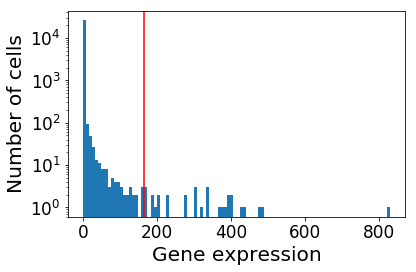

In [16]:
scprep.plot.plot_gene_set_expression(data, genes=['LOC101885394'], log='y', cutoff=164)

In [17]:
data, metadata = scprep.filter.filter_gene_set_expression(data, metadata, genes=['LOC101885394'], cutoff=164)

### Library size normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In `scprep` this is performed using the `normalize` method `library_size_normalize()`.

In [18]:
data_libnorm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

In [20]:
metadata['library_size'] = libsize
metadata.head()

,clusterID,sample_labels,genotype,cluster,libsize,library_size
DEW193_TGGGAATT_AGAGACTA_chdA,9,chdA,chd,hatching gland,12786.0,12786.0
DEW193_TATCTGTC_CTTCGCAC_chdA,4,chdA,chd,differentiating neurons - rohon beard,5267.0,5267.0
DEW193_AGGGTAAA_AAAGCCTA_chdA,27,chdA,chd,tailbud - PSM,4438.0,4438.0
DEW193_CCCGTTCT_GCTTTGGC_chdA,27,chdA,chd,tailbud - PSM,4054.0,4054.0
DEW193_CCAGACAG_TGGGATTC_chdA,27,chdA,chd,tailbud - PSM,3559.0,3559.0


### Square root transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log{0}$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

There are a number of transformations implemented in [`scprep.transform`](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.transform).

In [21]:
data_sqrt = scprep.transform.sqrt(data_libnorm)

### Examining the number of cells in each sample past filtering



First, we create a colormap for visualizating the samples. You can select colors by hex code with Google's [RGB color picker](https://www.google.com/search?client=firefox-b-1-d&q=rgb+color+picker).

In [17]:
sample_cmap = {'chdA' : '#fb6a4a',
                'chdB' : '#de2d26',
                'chdC' : '#a50f15',
                'tyrA' : '#6baed6',
                'tyrB' : '#3182bd',
                'tyrC' : '#08519c'}

As we can see in the following plot, there are many more cells that passed QC in the chdA condition relative to the other samples. To account for this, the EES algorithm automatically normalizes each replicate to account for varying numbers of cells.



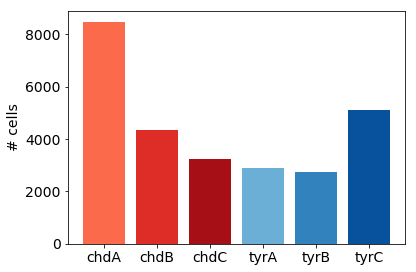

In [23]:
fig, ax = plt.subplots(1)

groups, counts = np.unique(metadata['sample_labels'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c, color=sample_cmap[groups[i]])
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()
fig.savefig("./cells_per_sample.png", dpi=300)

## 3. Embedding Data Using PHATE

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.


Here's the simplest way to apply PHATE:
```python
phateop = phate.PHATE(knn=9, decay=10, gamma=0, n_jobs=-2)
Y = phateop.fit_transform(data_sq)
```

In [24]:
data_pca = scprep.reduce.pca(data_sqrt)

phate_op = phate.PHATE(knn=10, decay=10, n_jobs=12)
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 26827 cells and 100 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 43.78 seconds.
    Calculating affinities...
    Calculated affinities in 79.81 seconds.
  Calculated graph and diffusion operator in 125.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 37.92 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.01 seconds.
  Calculated landmark operator in 61.98 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.37 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.73 seconds.
Calculated PHATE in 193.68 seconds.


### Coloring a PHATE plot by sample ID

And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

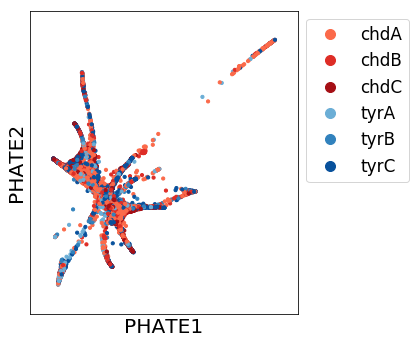

In [33]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], cmap=sample_cmap, 
                      legend_anchor=(1,1), figsize=(6,5), s=10, label_prefix='PHATE', ticks=False)

### Coloring a PHATE plot by ClusterIDs

In Wagner et al. (2018), cells from the *chd* and *tyr* conditions were assigned cluster IDs through projection back to a reference dataset. In the published analysis, these number of cells mapping to each cluster in the *chd* vs *tyr* condition was used at the measure of *chd* loss-of-function on that cluster. To visualize the relationships between these clusters, we will color the PHATE plot by each cell's published ClusterID.

/home/dan/.local/lib/python3.8/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


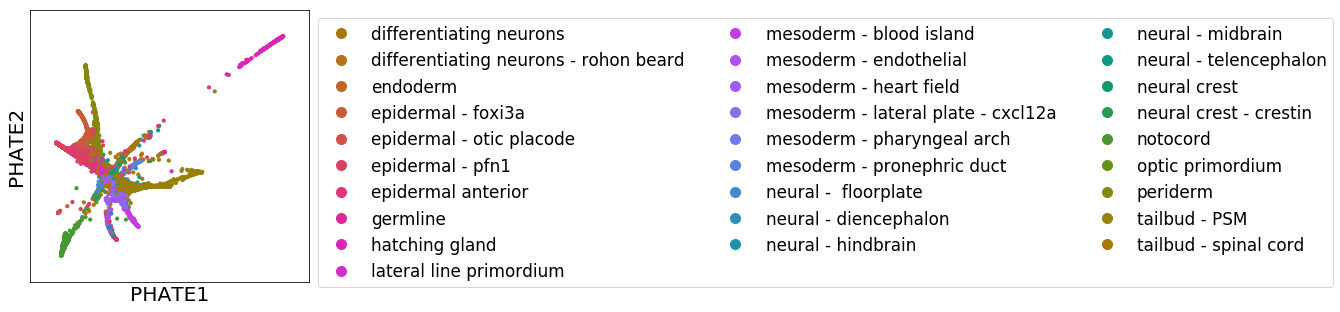

In [30]:
scprep.plot.scatter2d(data_phate, c=metadata['cluster'], cmap=cmocean.cm.phase, 
                      legend_anchor=(1,1), figsize=(5,5), s=10, label_prefix='PHATE', ticks=False)

### Interpreting the PHATE plot

Examining this PHATE plot, we see observe a complex many-branched structure. We can see that each region or branch of the PHATE plot is enriched for various clusters. However, you may notice that there are some clusters that occupy several branches of the plot. This is one of the issues with clustering - it is not perfect and the diversity within each cluster may not be uniform across clusters.

## 4. Using MELD to learn an Enhanced Experimental Signal

The key of MELD analysis is the Enhanced Experimental Signal (EES). The EES characterizes how prototypical a given cell is of each experimental condition. For example, in a simple experiment with one experimental condition and one control condition, EES is +1 or 0 for cells that are most likely to arise in the experimental or control condition, respectively, and 0.5 for cells equally likely to arise in either condition.

We can then use the EES to identify which cells are the most prototypical of each experimental condition, and which cell types are unchanging across conditions. We can also use this value to identify the gene signature of a perturbation (*i.e.* the genes that change the most across experimental conditions).

#### Separating replicate and conditions

We run the EES algorithm on each sample independently, then normalize within each replicate. First we're going to create a vector that indicated the replicate that each cell was sequenced in.

In [6]:
metadata['genotype'] = [1 if sl.startswith('chd') else 0 for sl in metadata['sample_labels']]
metadata['replicate'] = [sl[-1] for sl in metadata['sample_labels']]

#### Running the EES algorithm

In [2]:
import scanpy as sc

In [7]:
adata = sc.AnnData(data, obs=metadata)
adata.obsm['X_PHATE'] = data_phate

In [8]:
adata.write_h5ad('/home/dan/data/Klein_for_tutorial.h5ad')

... storing 'replicate' as categorical


In [2]:
adata = sc.read_h5ad('/home/dan/data/Klein_for_tutorial.h5ad')

data = adata.to_df()
metadata = adata.obs
data_phate = adata.obsm['X_PHATE']

In [4]:
data_pca = scprep.reduce.pca(data)

### Parameter search

As noted in our manuscript, the optimal filter and graph parameters for the EES algorithm can vary with dataset size and structure. To select parameters automatically, we added a framework to generate many random signals over a dataset and calculate the accuracy of the EES algorithm with different graph and filter parameters.

The base unit of this parameter search is the `meld.Benchmarker()` class

In [5]:
G = gt.Graph(data, n_pca=100, knn=20, use_pygsp=True)

In [9]:
meld_op = meld.MELD()
EES = meld.MELD().fit_transform(G, RES=metadata['sample_labels'])

Building graph on 26827 samples and 29197 features.


In [10]:
def replicate_normalize_EES(EES, replicate):
    replicates = np.unique(replicate)
    EES_norm = EES.copy()
    for rep in replicates:
        curr_cols = EES.columns[[col.endswith(rep) for col in EES.columns]]
        EES_norm[curr_cols] = sklearn.preprocessing.normalize(EES[curr_cols], norm='l1')
    return EES_norm

In [11]:
EES_norm = replicate_normalize_EES(EES, metadata['replicate'])

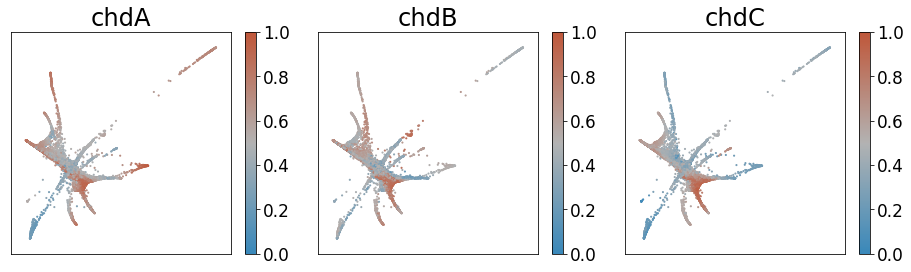

In [12]:
fig, axes = plt.subplots(1,3, figsize=(13,4))

experimental_samples = ['chdA', 'chdB', 'chdC']

for i, ax in enumerate(axes):
    curr_sample = experimental_samples[i]
    scprep.plot.scatter2d(data_phate, c=EES_norm[curr_sample], cmap=meld.utils.get_meld_cmap(),
                          vmin=0, vmax=1,
                          title=curr_sample, ticks=False, ax=ax)

fig.tight_layout()


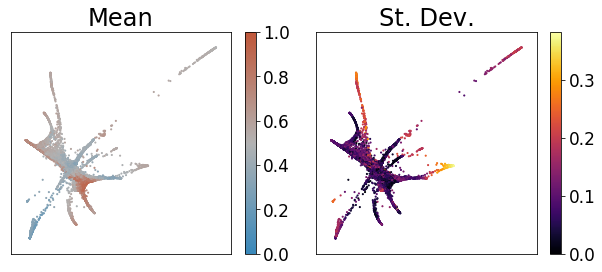

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8.7,4))

scprep.plot.scatter2d(data_phate, c=EES_norm[experimental_samples].mean(axis=1), 
                      cmap=meld.utils.get_meld_cmap(), vmin=0, vmax=1,
                      title='Mean', ticks=False, ax=axes[0])
scprep.plot.scatter2d(data_phate, c=EES_norm[experimental_samples].std(axis=1), vmin=0, 
                      cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

fig.tight_layout()

In [14]:
metadata['EES'] = EES_norm[experimental_samples].mean(axis=1).values

### Coloring a PHATE plot by the EES

### 5.2 Examining the distribution of EES values in published clusters

In [29]:
samples_cdict = {'chdA': '#fb6a4a',
                 'chdB': '#de2d26',
                 'chdC': '#a50f15',
                 'tyrA': '#6baed6',
                 'tyrB': '#3182bd',
                 'tyrC': '#08519c'}

samples_cvec = np.array([samples_cdict[s] for s in metadata['sample_label']])

Let's sort the index of each cluster from lowest to highest average EES value

In [15]:
metadata['clusterID'] = scprep.utils.sort_clusters_by_values(metadata['clusterID'], metadata['EES'])

#### Create jitter plots

These show the distribution of EES values within each cluster. Each point is a cell and the y-axis is the EES. The slight jitter in the x-xais is  only to help show density within each cluster.

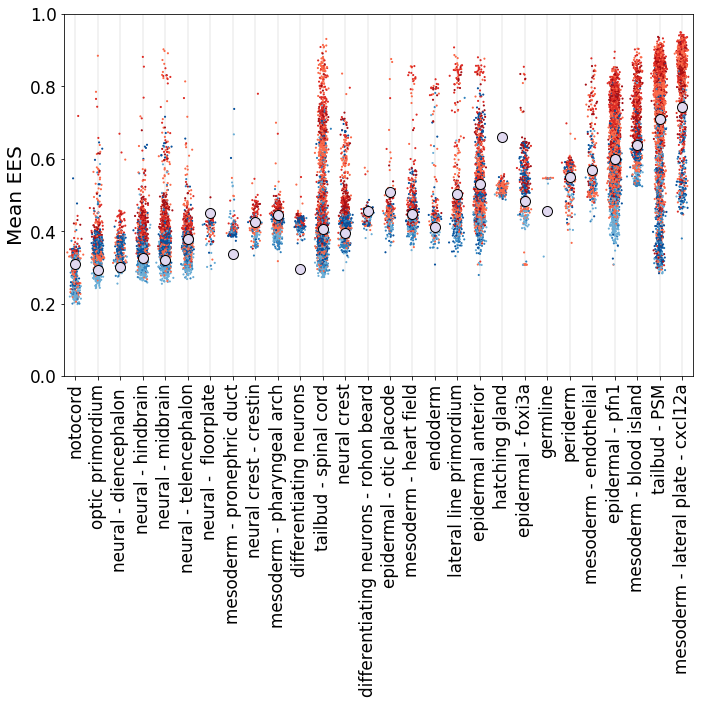

In [18]:
fig, ax = plt.subplots(1, figsize=(10,10))

# See example usage: https://scprep.readthedocs.io/en/stable/examples/jitter.html
scprep.plot.jitter(metadata['clusterID'], metadata['EES'], c=metadata['sample_labels'], 
                   cmap=sample_cmap,legend=False, plot_means=False, xlabel=False, ylabel='Mean EES',
                   ax=ax)

### This code will plot the ratio of tyr:chd cells per cluster
means = metadata.groupby('clusterID')['genotype'].mean()
ax.scatter(means.index, means - np.mean(metadata['genotype']) + 0.5, color='#e0d8f0', edgecolor='k', s=100)

# Axis tick labels
ax.set_xticklabels(metadata.set_index('clusterID')['cluster'].drop_duplicates().sort_index(), rotation=90)
ax.set_ylim(0,1)

fig.tight_layout()

####  Interpreting the plot

Here, we can see the distribution of EES values for each cell organized by the clusterID assigned by Wagner et al. (2018). Due to the issues with clustering above, we see that some clusters contain "outliers." For example, in the cluster on the far left, "optic primordium", has an average EES value of around -0.28, indicating that these cells are generally more prototypical in the tyrosinase condition. This is consisten with the observed reduced head size in *chd* mutant zebrafish (See Wanger et al. 2018 for a thorough description of the mutant phenotype). However, there are also some cells with very high EES values, and a couple with values around 0.55. This is a result of the clustering assigning the same cluster label to cells that are not adjacent on the cell similarity graph. 

This problem is especially apparent with the `tailbud - spinal cord` and `tailbud - PSM`* populations where the range of EES values in each group is especially large. In the MELD publication, we focued on the tailbud - presomitic mesoderm population. So let's start there.

\*(PSM = presomitic mesoderm)

## 6. Using VFC to subcluster each published cluster


Here, we're going to select and arbitrary cutoff that we only want to consider clusters that have at least 1% of the data for further clustering. For this dataset, that means we'd consider clusters with >268 cells.

In [23]:
# Get cluster indicides and number of cells per cluster
clusters, counts = np.unique(metadata['clusterID'], return_counts=True)

# Keep cluster labels with at least 1% of the data
clusters = clusters[counts > data.shape[0] * 0.01]

In [28]:
data_cluster_phate = {}

for cluster in np.unique(metadata['clusterID']):
    curr_data = data_pca.loc[metadata['clusterID'] == cluster]
    data_cluster_phate[cluster] = phate.PHATE(verbose=0).fit_transform(curr_data)
 


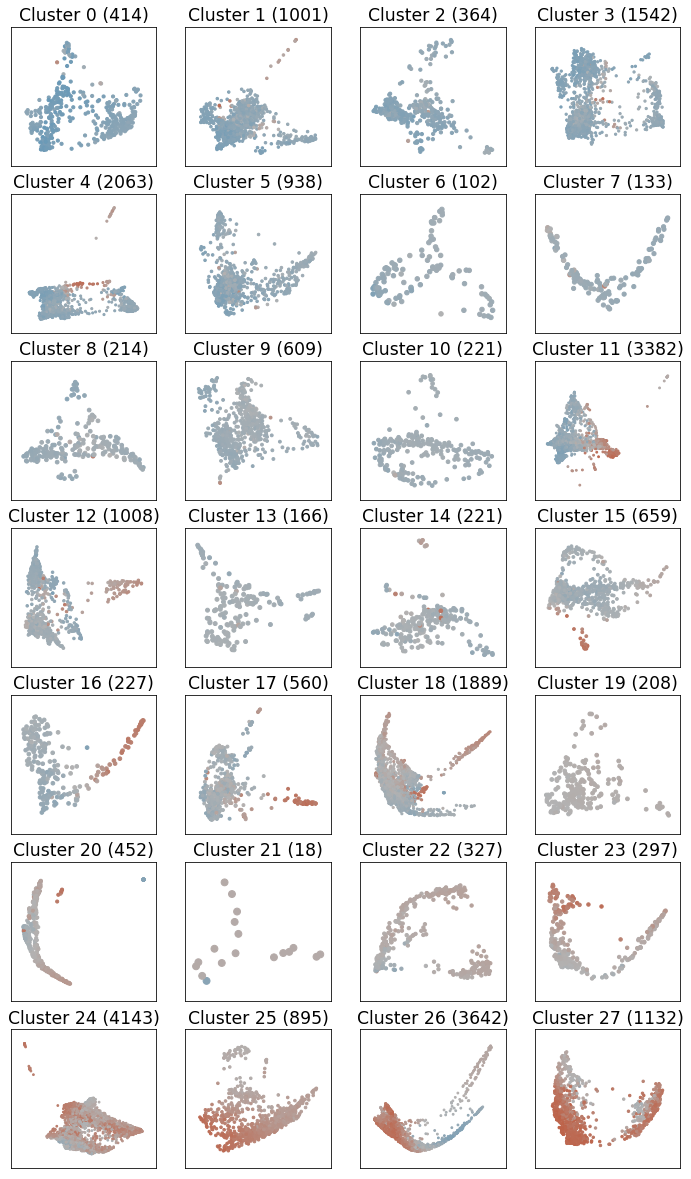

In [34]:
fig,axes= plt.subplots(7,4, figsize=(12, 21))

for i , ax in enumerate(axes.flatten()):
    if i > np.max(metadata['clusterID']):
        ax.axis('off')
        continue
    curr_phate = data_cluster_phate[i]
    
    scprep.plot.scatter2d(curr_phate, 
                          c=metadata['EES'].loc[metadata['clusterID'] == i], 
                          cmap=meld.utils.get_meld_cmap(), vmin=0, vmax=1,
                         ax=ax, ticks=False, 
                          title='Cluster {} ({})'.format(i, curr_phate.shape[0]), 
                          legend=False, fontsize=10)

## 6. Isolating the Tailbud - Presomitic Mesoderm cluster

Here, we will create a mask on the data to select the cells corresponding to the `tailbud - presomitic mesoderm` cluster and visualize these cells using PHATE.

### 6.1 Plotting the TPM cluster using PHATE

In [32]:
is_in_tailbud_psm = metadata['cluster'] == 'tailbud - PSM'
data_psm, data_magic_psm, metadata_psm = scprep.select.select_rows(data_sqrt, data_magic, metadata, idx=is_in_tailbud_psm)

In [33]:
G_psm = gt.Graph(data_psm, n_pca=100, knn=4, decay=30, use_pygsp=True, 
                 n_jobs=-2, verbose=True)
phate_op = phate.PHATE(knn_dist='precomputed', n_jobs=-2)
data_phate_psm = phate_op.fit_transform(G_psm.kernel)

Calculating PCA...
Calculated PCA in 3.43 seconds.
Calculating KNN search...
Calculated KNN search in 0.65 seconds.
Calculating affinities...
Calculated affinities in 0.16 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 3329 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 16.71 seconds.
  Calculated landmark operator in 18.32 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 1.00 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 25.02 seconds.
Calculated PHATE in 44.70 seconds.


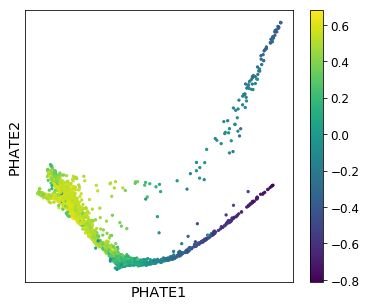

In [34]:
scprep.plot.scatter2d(data_phate_psm, c=metadata_psm['EES'], cmap='viridis', 
                      figsize=(6,5), s=5, label_prefix="PHATE", ticks=False)

####  Interpreting the PHATE plot

Looking at this plot, we observe several branching structures in the data, indicating that there are probably multiple cell types within the `tailbud - PSM`. Furthermore, we can see that the EES values within these cells are not uniformly distributed on the PHATE plot. In fact, some regions of the plot are enriched for high EES values and other are enriched for low values. From this, we can hypothesize that the wide range of scores in the `tailbud - PSM` is due to multiple cell types within this group that each exhibit different responses to *chd* loss-of-function.

### 6.2 Vertex Frequency Clustering

To handle this problem, we developed a method called **vertex frequency clustering**. The algorithm is described in the MELD manuscript, but the goal of this algorithm is to indentify cells that are both 1) transcriptionally similiar and 2) exhibit uniform responses to the experimental perturbation. The algorithm is implemented in the `meld.VertexFrequencyCluster` class. 

This class works similarly to the `sklearn` clustering classes, and all it needs is the graph `G`, the `RES` and the `EES` to create a matrix called the spectrogram. Currently, we use `KMeans` to do clustering on the spectrogram, so you must set `k`. Picking `k` is an imperfect science. We arrived at `k=4` for this dataset after trying several numbers of clusters and inspecting the expression of previously characterized marker genes for tissues in the zebrafish embryo.

Note that we set the random seed here, since `KMeans` does not produce the same output every time.

In [35]:
VFC_op = meld.VertexFrequencyCluster(n_clusters=4, random_state=42)

clusters = VFC_op.fit_predict(G_psm, RES=metadata_psm['RES'], EES=metadata_psm['EES'])

2019-09-18 12:35:33,804:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3329 x 3329) may take some time.


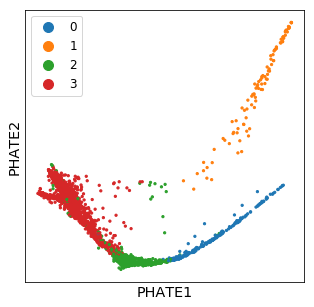

In [36]:
scprep.plot.scatter2d(data_phate_psm, c=clusters, 
                      figsize=(5,5), s=5, label_prefix="PHATE", ticks=False)

### 6.3 Characterizing clusters by marker genes

Let's characterize these four cell subtypes. Here we plot the expression of cell type markers obtained from [Farell et al (2018)](http://doi.org/10.1126/science.aar3131) with `scprep.plot.marker_plot`.

In [37]:
markers = {'Adaxial - Immature': ['myl10', 'myod1'],
           'Adaxial - Mature': ['myog'],
           'Presomitic mesoderm': ['tbx6', 'msgn1', 'tbx16'],
           'Somites': [ 'mespba', 'ripply2', 'ripply1', 'aldh1a2']}

In [38]:
data_sqrt.head()

Row,LOC100000009,LOC100000058,LOC100000086,LOC100000094,LOC100000098,LOC100000110,LOC100000119,LOC100000140,LOC100000155,LOC100000156,...,zte38,zufsp,zw10,zwi,zwilch,zyg11,zymnd12,zyx,zzef1,zzz3
DEW193_TATCTGTC_CTTCGCAC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000
DEW193_AGGGTAAA_AAAGCCTA_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.208912,0.0,0.0000
DEW193_CCCGTTCT_GCTTTGGC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.264872,0.0,0.8944
DEW193_GTCTGGAA_TAACCCGT_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.040232,0.0,0.0,0.0,0.0,2.080463,0.0,0.0000
DEW193_TCTAAACT_CGGCTTAC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.491921,0.0,0.0000


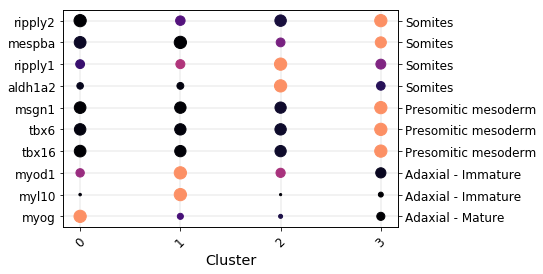

In [39]:
scprep.plot.marker_plot(data_psm, clusters, gene_names=data_sqrt.columns, markers=markers)

Perfect. We now know that cluster 0 is Adaxial - Mature, cluster 1 is Adaxial - Immature, cluster 2 is Somites, and cluster 3 is Presomitic mesoderm.

#### Assigning cluster names

Now that we know what cell type is in each cluster, we can assign labels to each group.

In [40]:
cluster_names = np.empty_like(clusters, dtype=object)
cluster_names[clusters == 0] = 'Adaxial - mature'
cluster_names[clusters == 1] = 'Adaxial - immature'
cluster_names[clusters == 2] = 'Somites'
cluster_names[clusters == 3] = 'Presomitic mesoderm'
metadata_psm = metadata_psm.assign(psm_cluster=cluster_names)
metadata_psm.head()

,clusterID,sample_label,RES,cluster,libsize,EES,psm_cluster
DEW193_AGGGTAAA_AAAGCCTA_chdA,26,chdA,1,tailbud - PSM,4438,0.542300,Presomitic mesoderm
DEW193_CCCGTTCT_GCTTTGGC_chdA,26,chdA,1,tailbud - PSM,4054,0.552210,Presomitic mesoderm
DEW193_GGTTAGGG_GCTTTGGC_chdA,26,chdA,1,tailbud - PSM,1825,-0.221582,Adaxial - mature
DEW193_TCATTTCA_ATATACCT_chdA,26,chdA,1,tailbud - PSM,3961,0.543111,Presomitic mesoderm
DEW193_TCGTTCCC_ACATCTAT_chdA,26,chdA,1,tailbud - PSM,4206,-0.053039,Adaxial - immature


In [41]:
# Create colormap
psm_cluster_cmap = {'Adaxial - immature':  '#d7dfc0',
                    'Adaxial - mature'  :  '#75b490',
                    'Somites':             '#426c84',
                    'Presomitic mesoderm': '#2c1e3e'}

And now we can recreate that plot with the proper labels and colors

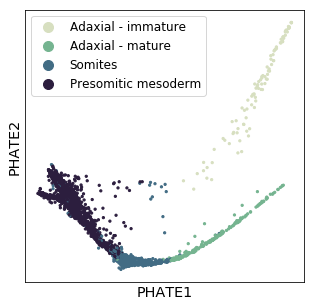

In [42]:
scprep.plot.scatter2d(data_phate_psm, c=metadata_psm['psm_cluster'], cmap=psm_cluster_cmap,
                      figsize=(5,5), s=5, label_prefix="PHATE", ticks=False)

### 6.4 Inspecting EES values in vertex frequency clusters

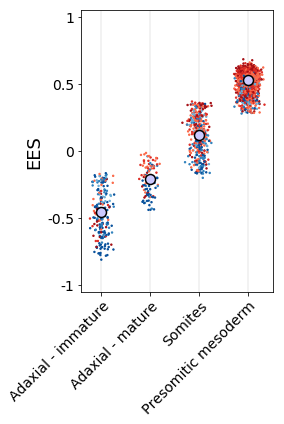

In [43]:
fig, ax = plt.subplots(1, figsize=(4,6))


# Expt. labels

plot_EES_in_clusters(ax, clusters, metadata_psm['EES'], c=samples_cvec[is_in_tailbud_psm])

# Y axis
ax.set_ylim((-1.05, 1.05))
ax.set_yticks([-1, -0.5, 0,0.5, 1])
ax.set_yticklabels([-1, -0.5, 0,0.5, 1], fontsize=12)
ax.set_ylabel('EES', fontsize=18)

# x axis
ax.set_xticks(np.arange(len(psm_cluster_cmap.keys())))
ax.set_xticklabels(list(psm_cluster_cmap.keys()), rotation=45, ha='right', fontsize=14)
ax.tick_params(labelsize=14)
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

fig.tight_layout()

#### Interpreting this plot

Here, we can see that the wide range of EES values in the `tailbud - PSM` tissue is due to the presence of multiple cell types with different responses to chordin mutagenesis. In fact, the depletion of the adaxial/myotomal cells (indicated by lower EES values) in chordin mutants is well documented  as is the expansion of the presomitic and somitic tissues (PMID: [9007232](https://www.ncbi.nlm.nih.gov/pubmed/9007232); [10581032](https://www.ncbi.nlm.nih.gov/pubmed/10581032)).

## 7. Using the EES to identify gene trends in subtissues of the `tailbud - PSM`

Here, we're going to use the EES to examine changes in gene expression associated with the loss of chordin for each of the clusters identified in the previous section. To do this, we're going to take the top and bottom 20% of cells in each cluster by EES value, and compare the expression of two genes known to be affected by chordin loss-of-function. 

We will compare this analysis to simply looking at the differences across the tissue as a whole and simply comparing the two conditions. Here, you will see how the clusters identified with Vertex Frequency Clustering reveal a finer resolution than examining the published cluster. We will also see how using the EES to isolate the cells within each cluster that are the most prototypical of each condition enhances subtle changes in gene expression that would be lost through direct comparison of the sample label (*i.e.* the RES).

### 7.1 Examining expression of `tbx6` and `myod1` in the published cluster using the RES

Here, we're plotting density-normalized histograms of gene expression in the *chd* and *tyr* conditions.

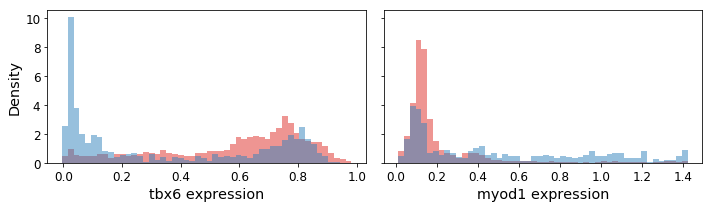

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), sharey='row')

# Whole cluster, tyr only
for gene, ax in zip(['tbx6', 'myod1'], axes):
    expression = scprep.select.select_cols(data_magic_psm, idx=gene)
    
    expression_tyr = scprep.select.select_rows(expression, idx=metadata_psm['RES'] == -1)
    expression_chd = scprep.select.select_rows(expression, idx=metadata_psm['RES'] == +1)
    
    scprep.plot.histogram([expression_tyr, expression_chd], ax=ax, bins=50, 
                          density=True, histtype='stepfilled', alpha=0.5, color=['#3182bd', '#de2d26'],
                          xlabel='{} expression'.format(gene), ylabel='Density' if gene == 'tbx6' else None)
fig.tight_layout()

Here, we see lower expression of `tbx6` in the *tyr* condition (blue) compared to the *chd* condition (red) and the inverse is true for `myod1`. However, as we showed above, the `tailbud - PSM` is actually an amalgamation of several kinds of cells. Now, we want to see if separating the cells into cell types clarifies the change in gene expression.

In the following plots, we're going to separate the gene expression from each of the clusters and show their distribution

/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.

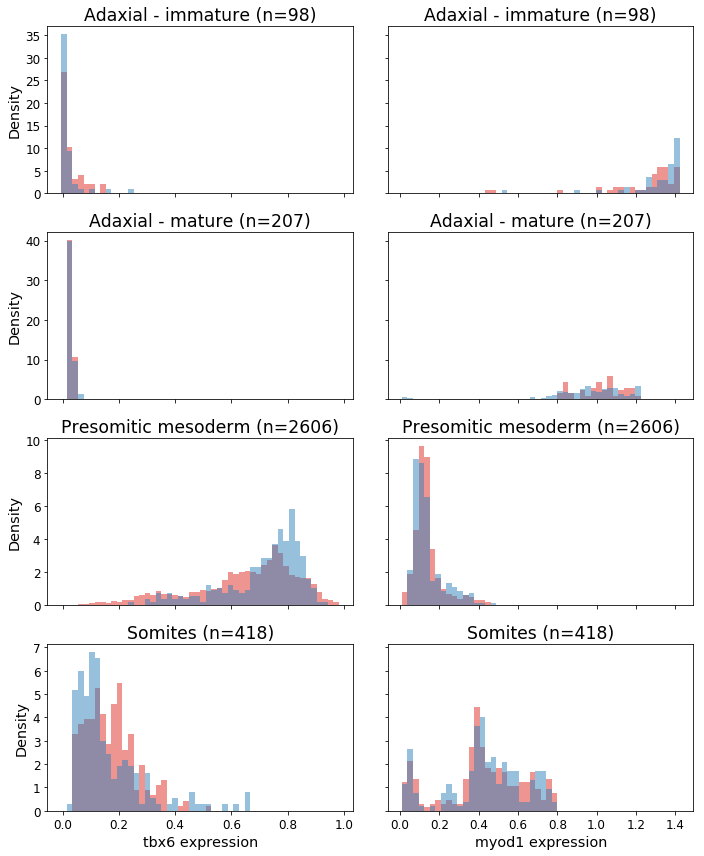

In [45]:
fig, axes = plt.subplots(4,2, figsize=(10,12), sharex='col', sharey='row')

for j, gene in enumerate(['tbx6', 'myod1']):
    expression = scprep.select.select_cols(data_magic_psm, idx=gene)
    expression_range = (np.min(expression), np.max(expression))
    
    for i, cluster_name in enumerate(np.unique(metadata_psm['psm_cluster'])):
        ax = axes[i,j]
        in_cluster = metadata_psm['psm_cluster'] == cluster_name
        cluster_expression_tyr = scprep.utils.select_rows(
            expression, (metadata_psm['RES'] == -1) & in_cluster)
        cluster_expression_chd = scprep.utils.select_rows(
            expression, (metadata_psm['RES'] == +1) & in_cluster)
        
        scprep.plot.histogram([cluster_expression_tyr, cluster_expression_chd], 
                              ax=ax, log=False, range=expression_range, bins=50, 
                              density=True, histtype='stepfilled', alpha=0.5, color=['#3182bd', '#de2d26'], 
                              xlabel='{} expression'.format(gene) if i == 3 else None, 
                              ylabel='Density' if gene == 'tbx6' else None,
                              title='{} (n={})'.format(cluster_name, np.sum(in_cluster)))
fig.tight_layout()

### 7.2 Using the EES to identify cells most affected by *chd* loss-of-function

Here, we can see very clearly that the differences in gene expression within the published cluster is due to the presence of multiple populations of cells within that group.

However, we will see only a subtle difference in gene expression within each of these clusters. To emphasize the differences between the two samples, we can take only the cells with the lowest and highest EES values because these are the cells that are the most prototypical of the control and experimental condidions, respectively. Specifically, we're going to focus on the cells in the top and bottom 20th percentiles.


Below, the horizontal black bars represent these cutoffs for each cluster.


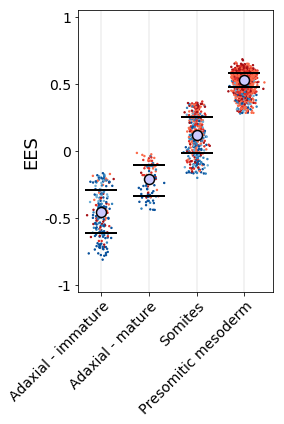

In [46]:
fig, ax = plt.subplots(1, figsize=(4,6))

# Expt. labels

plot_EES_in_clusters(ax, clusters, metadata_psm['EES'], c=samples_cvec[is_in_tailbud_psm])

# Y axis
ax.set_ylim((-1.05, 1.05))
ax.set_yticks([-1, -0.5, 0,0.5, 1])
ax.set_yticklabels([-1, -0.5, 0,0.5, 1], fontsize=12)
ax.set_ylabel('EES', fontsize=18)

# x axis
ax.set_xticks(np.arange(len(psm_cluster_cmap.keys())))
ax.set_xticklabels(list(psm_cluster_cmap.keys()), rotation=45, ha='right', fontsize=14)
ax.tick_params(labelsize=14)
scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.15)

# Plotting the top and bottom 20th percentiles
for c in np.unique(clusters):
    curr_EES = metadata_psm['EES'][clusters == c]
    curr_high = np.percentile(curr_EES, 80)
    curr_low = np.percentile(curr_EES,  20)
    ax.scatter(c, curr_high, marker='_', c='k', s=1000, lw=2)
    ax.scatter(c, curr_low,  marker='_', c='k', s=1000, lw=2 )

fig.tight_layout()

Now, we can create histograms as above, but only using the cells with EES values in the top 20th percentile (red) and bottom 20th percentile (blue).

/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.select_rows` is deprecated. Use `scprep.select.select_rows` instead.
  FutureWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:470: FutureWarning: `scprep.utils.

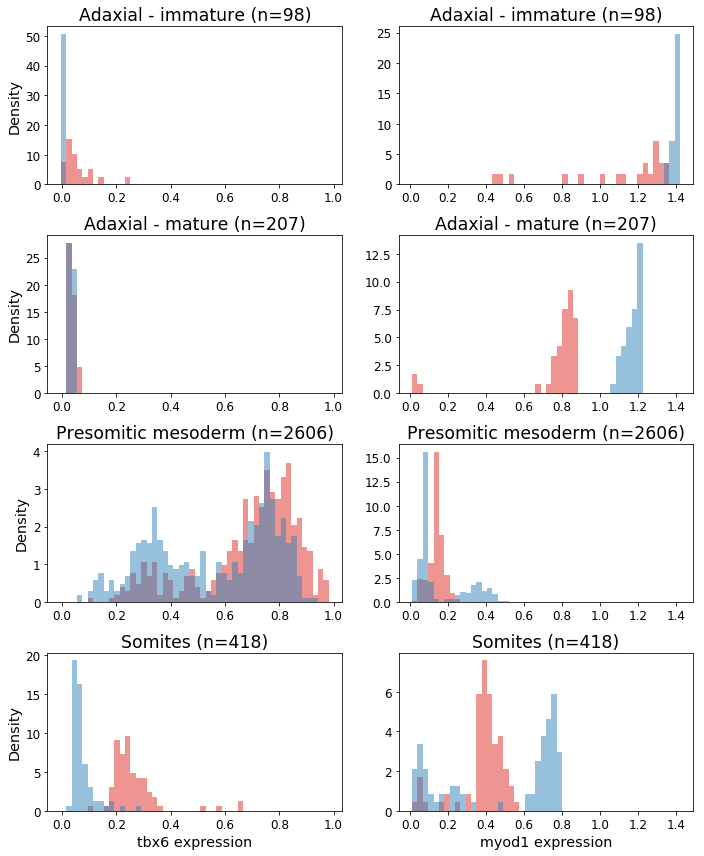

In [47]:
fig, axes = plt.subplots(4,2, figsize=(10,12))

for j, gene in enumerate(['tbx6', 'myod1']):
    expression = scprep.select.select_cols(data_magic_psm, idx=gene)
    expression_range = (np.min(expression), np.max(expression))
    
    for i, cluster_name in enumerate(np.unique(metadata_psm['psm_cluster'])):
        ax = axes[i,j]
        
        in_cluster = metadata_psm['psm_cluster'] == cluster_name
        
        cluster_EES = metadata_psm['EES'][in_cluster]
        # Calculate percentiles
        EES_high = np.percentile(cluster_EES, 80)
        EES_low = np.percentile(cluster_EES, 20)
        
        cluster_expression_tyr = scprep.utils.select_rows(
            expression, (metadata_psm['EES'] < EES_low) & in_cluster)
        cluster_expression_chd = scprep.utils.select_rows(
            expression, (metadata_psm['EES'] > EES_high) & in_cluster)
        
        scprep.plot.histogram([cluster_expression_tyr, cluster_expression_chd], 
                              ax=ax, log=False, range=expression_range, bins=50, 
                              density=True, histtype='stepfilled', alpha=0.5, color=['#3182bd', '#de2d26'], 
                              xlabel='{} expression'.format(gene) if i == 3 else None, 
                              ylabel='Density' if gene == 'tbx6' else None,
                              title='{} (n={})'.format(cluster_name, np.sum(in_cluster)))

fig.tight_layout()

Although the effects here are subtle, we can see some differences in gene expression are emphasized.